In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import rdata
frequency = rdata.read_rda("data//fremotor1freq0304a.rda")
premium = rdata.read_rda("data//fremotor1prem0304a.rda")
severity = rdata.read_rda("data//fremotor1sev0304a.rda")
freq_df = frequency["fremotor1freq0304a"]
prem_df = premium["fremotor1prem0304a"]
sev_df = severity["fremotor1sev0304a"]
sev_df["OccurDate"] = pd.to_datetime(sev_df["OccurDate"], unit="D", origin="unix")
sev_df["OccurYear"] = sev_df["OccurDate"].dt.year
prem_df["DrivAgeBins"] = pd.cut(prem_df["DrivAge"],bins=20).map(lambda x: "(%s,%s]" % (x.left, x.right))

/opt/conda/lib/python3.12/site-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "Date". The underlying R object is returned instead.
  warnings.warn(


In [6]:
sev_df.pivot_table(index="Guarantee", values="Payment", aggfunc=["mean", "min", "max", "count"], observed=True)

,mean,min,max,count
,Payment,Payment,Payment,Payment
Guarantee,,,,
Damage,1876.576076,0,24728,953
Fire,2445.037383,0,12612,107
Other,798.441315,0,8756,213
Theft,1934.2,0,26266,575
TPL,1632.950262,0,632893,4202
Windscreen,284.432416,0,18035,3196


In [8]:
mask = sev_df["Guarantee"] == "Windscreen"
damage_df = sev_df.loc[mask,:]

In [9]:
enriched_df = pd.merge(prem_df, damage_df, left_on=["IDpol","Year"], right_on=["IDpol","OccurYear"])


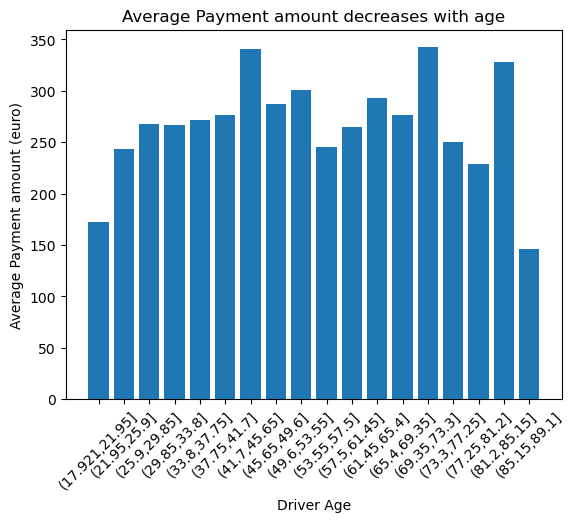

In [10]:
driv_age = enriched_df.pivot_table(index="DrivAgeBins",values="Payment",aggfunc="mean", observed=False).reset_index().copy()
fig, ax = plt.subplots()
ax.bar(x=driv_age["DrivAgeBins"], height=driv_age["Payment"])
ax.tick_params("x",rotation=45)
ax.set_xlabel("Driver Age")
ax.set_ylabel("Average Payment amount (euro)")
ax.set_title("Average Payment amount decreases with age")
plt.show()

/tmp/ipykernel_6795/267773157.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  veh_class = enriched_df.pivot_table(index="VehClass",values="Payment",aggfunc="mean").reset_index().copy()


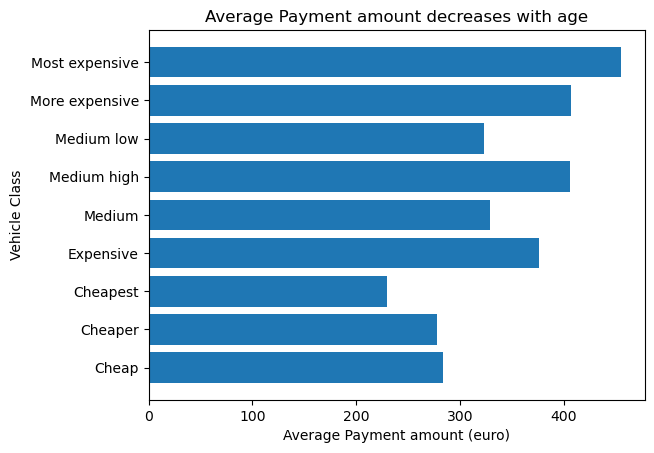

In [11]:
veh_class = enriched_df.pivot_table(index="VehClass",values="Payment",aggfunc="mean").reset_index().copy()
plt.barh(y=veh_class["VehClass"], width=veh_class["Payment"])
plt.ylabel("Vehicle Class")
plt.xlabel("Average Payment amount (euro)")
plt.title("Average Payment amount decreases with age")
plt.show()

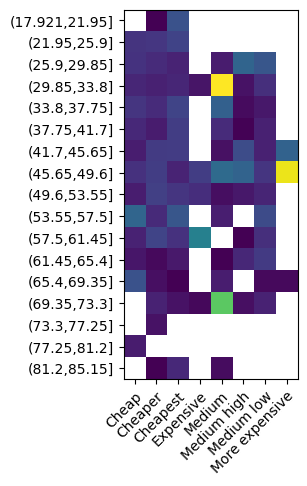

In [7]:
combo = enriched_df.pivot_table(index=["VehClass"], columns=["DrivAgeBins"],values="Payment",aggfunc="mean", observed=False).copy()
columns = []
for c in combo.columns:
    columns.append(combo[c].values)
column_labels = combo.columns.values
index_labels = combo.index.values
fig, ax = plt.subplots()
ax.imshow(columns)

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(index_labels)), labels=index_labels,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(column_labels)), labels=column_labels)

# for i in range(len(column_labels)):
#     for j in range(len(index_labels)):
#         text = ax.text(j, i, columns[i][j],
#                        ha="center", va="center", color="w")

plt.show()

In [34]:
enriched_df["VehClass"].unique()
vehclass_cat = ["Cheapest", "Cheaper", "Cheap", "Medium low", "Medium", "Medium high", "Expensive","More expensive", "Most expensive"]
ord_enc = LabelEncoder().fit(vehclass_cat)
vehpower_cat = ["P%s" % x for x in range(2,18)]
vehpower_cat



['P2',
 'P3',
 'P4',
 'P5',
 'P6',
 'P7',
 'P8',
 'P9',
 'P10',
 'P11',
 'P12',
 'P13',
 'P14',
 'P15',
 'P16',
 'P17']

In [33]:
enriched_df.pivot_table(index="VehPower", values="IDpol", aggfunc="count")

/tmp/ipykernel_6795/228408105.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  enriched_df.pivot_table(index="VehPower", values="IDpol", aggfunc="count")


,IDpol
VehPower,
P10,489
P11,492
P12,479
P13,437
P14,212
P15,77
P16,54
P17,2
P2,0


In [49]:

from sklearn.model_selection import train_test_split
X_cont = enriched_df.loc[:,["DrivAge", "BonusMalus"]].values
X_cat = enriched_df.loc[:,["MaritalStatus","VehUsage","Garage"]].values
X_ord_class = enriched_df.loc[:,["VehClass"]].values
X_ord_power = enriched_df.loc[:,["VehPower"]].values
y = enriched_df["Payment"]

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

vehclass_cat = ["Cheapest", "Cheaper", "Cheap", "Medium low", "Medium", "Medium high", "Expensive","More expensive", "Most expensive"]
vehpower_cat = ["P%s" % x for x in range(2,18)]

X_cat_transform = OneHotEncoder(drop='first').fit_transform(X_cat)
X_ord_class_transform = np.array(LabelEncoder().fit(vehclass_cat).transform(X_ord_class)).reshape(-1,1)
X_ord_power_transform = np.array(LabelEncoder().fit(vehpower_cat).transform(X_ord_power)).reshape(-1,1)
X_transform = np.concatenate((X_cont, X_cat_transform.toarray(), X_ord_class_transform, X_ord_power_transform), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_transform, y, test_size=0.33, random_state=42)


/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/conda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [53]:
from sklearn.tree import DecisionTreeRegressor
clf_tree = DecisionTreeRegressor(max_depth=10).fit(X_train, y_train)
print("The Tree model score is %.2f%%" % (clf_tree.score(X_test, y_test)*100))
y_tree = clf_tree.predict(X_test)

The Tree model score is -367.27%


In [54]:
from sklearn.linear_model import LinearRegression
clf_lin = LinearRegression().fit(X_train, y_train)
print("The Linear model score is %.2f%%" % (clf_lin.score(X_test, y_test)*100))
y_lin = clf_lin.predict(X_test)

The Linear model score is 1.63%


In [70]:
def perc_to_decile(val):
    if val == 1.0:
        return 10
    return int(val*10)+1

In [108]:
pred_df = pd.DataFrame({"Actual": y_test, "GBC": y_gbc, "Lin": y_lin})
pred_df.sort_values("GBC", inplace=True)
pred_df["DecileGBC"] = pred_df["GBC"].rank(pct=True).map(perc_to_decile)
pred_df["DecileLin"] = pred_df["Lin"].rank(pct=True).map(perc_to_decile)

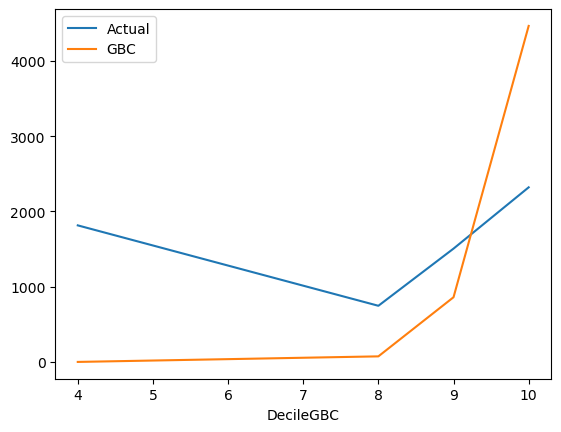

In [110]:
pred_df.loc[:,["DecileGBC","Actual", "GBC"]].groupby("DecileGBC").mean().plot()
plt.show()

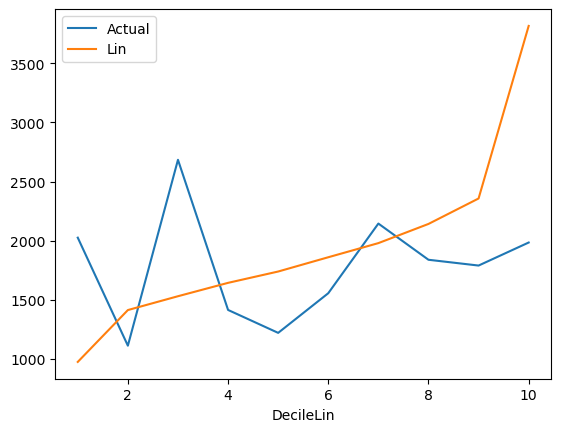

In [111]:
pred_df.loc[:,["DecileLin","Actual", "Lin"]].groupby("DecileLin").mean().plot()
plt.show()

In [78]:
X_transform

<790x64 sparse matrix of type '<class 'numpy.float64'>'
	with 1440 stored elements in Compressed Sparse Row format>